# Convolutional autoencoder for image denoising
### 卷积自编码器图像去噪

原文链接：https://keras.io/examples/vision/autoencoder/

## Note：

这个是一个非常简单的教程，使用卷积自编码器对加噪的MNIST图像进行去噪，所以这个博客不会花很多篇幅进行详解，可以将这个博客视作检查框架熟练度的工具。  

图像降噪其实是一个非常难的课题，因为这里使用的数据集很简单所以会发现效果十分显著，但不能因此觉得图像降噪没什么。  

此外这个博客是 [Fracois Chillet](https://blog.keras.io/building-autoencoders-in-keras.html) 的简化版本，心有余力的读者建议顺带阅读下他的博客。  

------------

## Setup

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model

In [2]:
def preprocess(array):
    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), 28, 28, 1))
    return array

In [3]:
def noise(array):
    noise_factor = 0.4
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )
    return np.clip(noisy_array, 0.0, 1.0)

In [4]:
def display(array1, array2):
    n = 10

    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

-------------

## Prepare the data

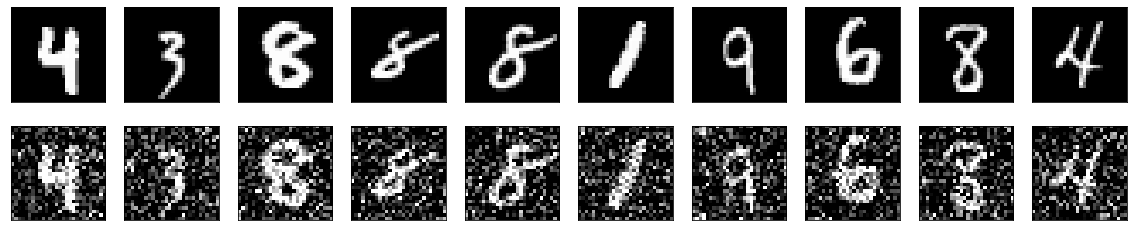

In [5]:
(train_data, _), (test_data, _) = mnist.load_data()

# 标准化 & reshape
train_data = preprocess(train_data)
test_data = preprocess(test_data)

# 创造含有噪声的数据
noisy_train_data = noise(train_data)
noisy_test_data = noise(test_data)

display(train_data, noisy_train_data)

---------

## Build the autoencoder

In [6]:
input = layers.Input(shape=(28, 28, 1))

# Encoder 编码器
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder 解码器
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")

---------

## Train & Evaluate
这里首先将模型训练成能够完成自编码的阶段，这样可以降低后面降噪训练的难度。

In [7]:
autoencoder.fit(
    x=train_data,
    y=train_data,
    epochs=10,
    batch_size=128,
    shuffle=True,
    validation_data=(test_data, test_data),
)

Epoch 1/10
469/469 [==============================] - 11s 11ms/step - loss: 0.1379 - val_loss: 0.0728
Epoch 2/10
469/469 [==============================] - 4s 9ms/step - loss: 0.0714 - val_loss: 0.0694
Epoch 3/10
469/469 [==============================] - 4s 9ms/step - loss: 0.0692 - val_loss: 0.0681
Epoch 4/10
469/469 [==============================] - 4s 9ms/step - loss: 0.0681 - val_loss: 0.0672
Epoch 5/10
469/469 [==============================] - 4s 9ms/step - loss: 0.0673 - val_loss: 0.0666
Epoch 6/10
469/469 [==============================] - 4s 9ms/step - loss: 0.0668 - val_loss: 0.0662
Epoch 7/10
469/469 [==============================] - 4s 9ms/step - loss: 0.0663 - val_loss: 0.0656
Epoch 8/10
469/469 [==============================] - 4s 9ms/step - loss: 0.0659 - val_loss: 0.0653
Epoch 9/10
469/469 [==============================] - 4s 9ms/step - loss: 0.0656 - val_loss: 0.0650
Epoch 10/10
469/469 [==============================] - 4s 9ms/step - loss: 0.0653 - val_loss: 0.06

检查自编码器的效果

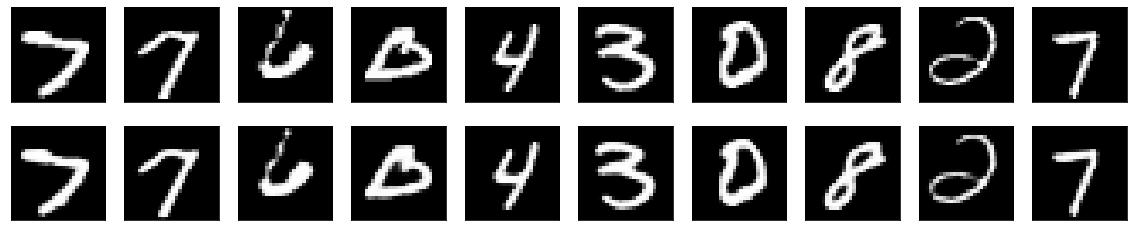

In [8]:
predictions = autoencoder.predict(test_data)
display(test_data, predictions)

模型能够完成自编码后，再进行深度的训练，将有噪声的数据送入模型。kera的模型支持中断再训练，即上一个fit结束后重新fit，模型的权重是按照上一个的结果进行调整，而不是从零开始。

In [9]:
autoencoder.fit(
    x=noisy_train_data,
    y=train_data,
    epochs=10,
    batch_size=128,
    shuffle=True,
    validation_data=(noisy_test_data, test_data),
)

Epoch 1/10
469/469 [==============================] - 4s 9ms/step - loss: 0.1000 - val_loss: 0.0931
Epoch 2/10
469/469 [==============================] - 4s 9ms/step - loss: 0.0928 - val_loss: 0.0912
Epoch 3/10
469/469 [==============================] - 4s 9ms/step - loss: 0.0913 - val_loss: 0.0901
Epoch 4/10
469/469 [==============================] - 4s 9ms/step - loss: 0.0904 - val_loss: 0.0893
Epoch 5/10
469/469 [==============================] - 4s 9ms/step - loss: 0.0897 - val_loss: 0.0887
Epoch 6/10
469/469 [==============================] - 4s 9ms/step - loss: 0.0891 - val_loss: 0.0882
Epoch 7/10
469/469 [==============================] - 4s 9ms/step - loss: 0.0887 - val_loss: 0.0880
Epoch 8/10
469/469 [==============================] - 4s 9ms/step - loss: 0.0883 - val_loss: 0.0876
Epoch 9/10
469/469 [==============================] - 4s 8ms/step - loss: 0.0880 - val_loss: 0.0872
Epoch 10/10
469/469 [==============================] - 4s 9ms/step - loss: 0.0877 - val_loss: 0.0871

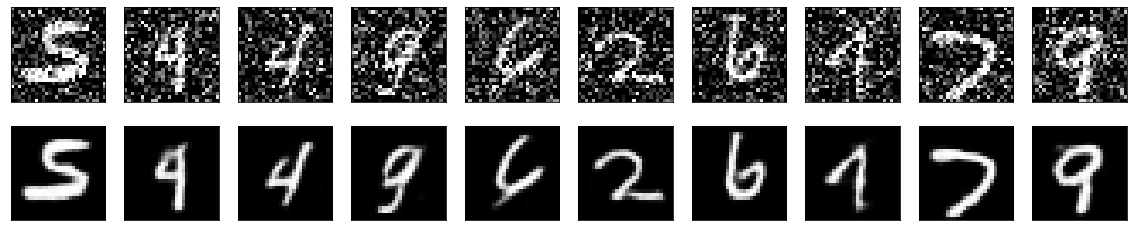

In [10]:
predictions = autoencoder.predict(noisy_test_data)
display(noisy_test_data, predictions)

从上面的结果来看，哪怕仅仅10+10个epoch的训练也能达到很好的效果，这是由于以下几点造成的：
* 数据集本身很简单。
* 模型首先完成了对干净数据的自编码训练，已经记住了数据集的特征，然后再进行降噪训练。
* 没有使用数据增强。